In [3]:
import torch
import pickle
import os
import sys
import scipy
from torchvision.utils import save_image
import dnnlib
import numpy as np

MODEL_PTH= '/home/lauh/projects/def-gambsseb/lauh/latent_space/00000-cifar10_mini-cond-cifar/network-snapshot-004032.pkl'
#save the literal filepath to both directories as strings
tu_path = os.path.join('/home/lauh/projects/def-gambsseb/lauh','stylegan2-ada-pytorch')#,'torch_utils')
dnnlib_path = os.path.join('/home/lauh/projects/def-gambsseb/lauh','stylegan2-ada-pytorch')#,'dnnlib')

#add those strings to python path
sys.path.append(tu_path)
sys.path.append(dnnlib_path)
print(sys.path)

with open('/home/lauh/projects/def-gambsseb/lauh/latent_space/00000-cifar10_mini-cond-cifar/network-snapshot-004032.pkl', 'rb') as f:
    model =  pickle.load(f)
G_ema = model['G_ema'].cuda() 
G = model['G'].cuda()  # torch.nn.Module
D = model['D'].cuda()
"""
for i in range(10):
    c= [0 for i in range(10)]
    z = torch.randn([1, G.z_dim]).cuda()    # latent codes
    c[2]=1.
    print(c)
    c = torch.tensor([c]).cuda()                                # class labels (not used in this example)
    img = G_ema(z, c, noise_mode='const')
    #w = G_ema.mapping(z, c, truncation_psi=1)#, truncation_cutoff=8)
    #img = G_ema.synthesis((w), noise_mode='random')#, force_fp32=True)
    save_image(img, 'img{}.png'.format(i))
    """

training_set_kwargs = dnnlib.EasyDict(class_name='training.dataset.ImageFolderDataset', path='/scratch/lauh/cifar10_membership.zip', use_labels=True, max_size=None, xflip=False)
training_set = dnnlib.util.construct_class_by_name(**training_set_kwargs)
member= torch.utils.data.Subset(training_set, list(range(5000)))
non_member= torch.utils.data.Subset(training_set, list(range(5000, 10000)))

member_loader= torch.utils.data.DataLoader(member, 32, False)
non_member_loader= torch.utils.data.DataLoader(non_member, 32, False)

preds_member=[]
for img,c in member_loader:
    pred= D(img.cuda(),c.cuda()).detach().cpu().numpy()
    preds_member.append(pred)

preds_non_member=[]
for img,c in non_member_loader:
    pred= D(img.cuda(),c.cuda()).detach().cpu().numpy()
    preds_non_member.append(pred)

preds_member= np.vstack(preds_member)
preds_non_member= np.vstack(preds_non_member)

['/project/6022344/lauh/stylegan2-ada-pytorch', '', '/cvmfs/soft.computecanada.ca/easybuild/python/site-packages', '/cvmfs/soft.computecanada.ca/custom/python/site-packages', '/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python38.zip', '/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8', '/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/lib-dynload', '/home/lauh/py37/lib/python3.8/site-packages', '/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/scipy-stack/2023a/lib/python3.8/site-packages', '/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/ipykernel/2023a/lib/python3.8/site-packages', '/home/lauh/projects/def-gambsseb/lauh/stylegan2-ada-pytorch', '/home/lauh/projects/def-gambsseb/lauh/stylegan2-ada-pytorch']
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


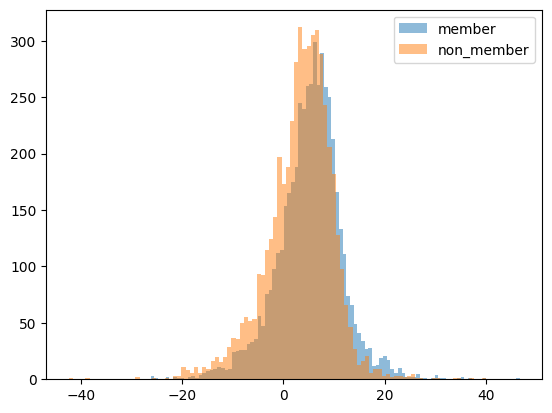

In [4]:
import matplotlib.pyplot as plt


plt.hist(preds_member, label='member', bins=100, alpha=.5)
plt.hist(preds_non_member, label='non_member', bins=100, alpha=.5)
plt.legend()
plt.show()

In [5]:
import pandas as pd
df_member=pd.DataFrame({'pred':preds_member[:,0], 'member':[1 for i in range(len(preds_member))]})
df_non_member=pd.DataFrame({'pred':preds_non_member[:,0], 'member':[0 for i in range(len(preds_member))]})
df= pd.concat([df_member, df_non_member], axis=0, ignore_index=True)

In [6]:
threshold= df.pred.quantile(.99)
df.loc[df.pred>=threshold, 'member'].mean()

0.71

### For images with the top 1% biggest loss, 71% of them are members

In [7]:
member_idx= df.loc[(df.pred>=threshold)&(df.member==1),:].index
member_idx=member_idx.tolist()

[   8,  103,  125,  216,  238,  292,  616,  631,  660,  796,  935,
             958, 1064, 1073, 1210, 1228, 1238, 1242, 1259, 1317, 1338, 1420,
            1447, 1453, 1485, 1549, 1807, 1876, 2119, 2147, 2152, 2177, 2179,
            2226, 2299, 2320, 2369, 2434, 2622, 2657, 2667, 2690, 2721, 2874,
            2893, 2958, 3098, 3139, 3180, 3277, 3369, 3401, 3419, 3536, 3574,
            3589, 3674, 3861, 4077, 4162, 4175, 4273, 4295, 4570, 4611, 4654,
            4721, 4731, 4843, 4888, 4999]

In [8]:
def get_img_id(img_idx):
    img_id=[]
    for img_nb in img_idx:
        folder_nb= img_nb//1000
        img_id.append(format(folder_nb, '05d')+ '/img'+format(img_nb, '08d')+'.png')
    return img_id

img_id= get_img_id(member_idx)

In [9]:
import json
  
# Opening JSON file
with open('/scratch/lauh/cifar10_mini/dataset.json') as f:
    labels_dict = json.load(f)
  
label_df=pd.DataFrame(labels_dict['labels'], columns=['id', 'label'])

In [10]:
member_df= label_df.loc[label_df.id.isin(img_id),:]
member_df

,id,label
8,00000/img00000008.png,8
103,00000/img00000103.png,6
125,00000/img00000125.png,6
216,00000/img00000216.png,8
238,00000/img00000238.png,1
...,...,...
4721,00004/img00004721.png,0
4731,00004/img00004731.png,6
4843,00004/img00004843.png,6
4888,00004/img00004888.png,2
